<p style="font-size:30px">Table of contents</p>

1. Initial Setup
2. Handling with PII data
3. Regional Segmentation
4. Low active customers slicing
5. Profiling
6. Visualizations
7. Exporting plots


**Note**: for a fully detailed ToC breakdown, I recommend opening this file on Jupyter Notebook and go to menu -> View -> Table of Contents, or press Ctrl+Shift+K (or Cmd instead of Ctrl for Mac users)

# Initial setup
Import the data set you exported in Task 4.9 into a new Jupyter notebook. This should be the merged version of your data that contains the new customers column.

In [1]:
#importing libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#setting up path variables

prep_data_path =  '../2_Data/2_Prepared_Data/'
vis_path = '../4_Analysis/3_Visualizations/'

In [3]:
#importing pickle files into working dataframe
#    (to be noted here that this file contains a 70% slice of the full orders dataset merged with customers
#     this partial random selection was due to memory restrictions)

df_ord_prod_cust = pd.read_pickle(os.path.join(prep_data_path, 'orders_products_customers.pkl'))

# Handling with PII data

Consider any security implications that might exist for this new data. You’ll need to address any Personal Identifiable Information in the data before continuing your analysis.

I've already addressed this issue while wrangling the dataframe with customers, before the merge. At the time, I wrote this:

*Drop the columns with the client names. It's a sensitive ethical issue, especially because there is extra personal info regarding dependants, family status, income, etc. Statistics will only be produced in aggregation. The user_id, however, shall remain because it will be the key to combine with orders dataset.*

And I ran the following code:

`df_customers.drop(labels=['First Name','Surnam'], axis=1, inplace=True)`

# Regional segmentation

Create a regional segmentation of the data. You’ll need to create a “Region” column based on the “State” column from your customers data set. 

Determine whether there’s a difference in spending habits between the different U.S. regions. (Hint: You can do this by crossing the variable you just created with the spending flag.)

In [4]:
#setup 4 lists with all the states for each region

ls_south_states = ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']
ls_west_states = ['Idaho', 'Montana', 'Wyoming','Nevada','Utah','Colorado','Arizona','New Mexico','Alaska','Washington','Oregon','California','Hawaii']
ls_northeast_states = ['Maine','New Hampshire','Vermont','Massachusetts','Rhode Island','Connecticut','New York','Pennsylvania','New Jersey']
ls_midwest_states = ['Wisconsin','Michigan','Illinois','Indiana','Ohio','North Dakota','South Dakota','Nebraska','Kansas','Minnesota','Iowa','Missouri']

In [5]:
#assign to the new region field, using .loc method, the value corresponding to the state existing in each list.

df_ord_prod_cust.loc[df_ord_prod_cust['state'].isin(ls_south_states), 'region'] = 'South'
df_ord_prod_cust.loc[df_ord_prod_cust['state'].isin(ls_west_states), 'region'] = 'West'
df_ord_prod_cust.loc[df_ord_prod_cust['state'].isin(ls_northeast_states), 'region'] = 'Northeast'
df_ord_prod_cust.loc[df_ord_prod_cust['state'].isin(ls_midwest_states), 'region'] = 'MidWest'

I'm confident in the process, I know that at this stage in case of any doubt, I could run `.value_counts()` in both fields (state and region) and do some cross verifications.

In any case, I'm running `value_counts()` on region to see distribution (and to see if eventually NaN values were created)

In [6]:
df_ord_prod_cust['region'].value_counts(dropna=False)

region
South        7555117
West         5806240
MidWest      5316195
Northeast    4005401
Name: count, dtype: int64

In [7]:
crosstab = pd.crosstab(df_ord_prod_cust['region'], df_ord_prod_cust['high_spender_flag'], dropna = False)

In [8]:
crosstab

high_spender_flag,False,True
region,,
MidWest,5295864,20331
Northeast,3992449,12952
South,7526752,28365
West,5784401,21839


In [9]:
#check in terms of percentage if in any of the regions the number of items ordered by high spenders do stand out

for index, row in crosstab.iterrows():
    print ('{}{}'.format(index.ljust(12), row[True]/(row[False] + row[True])))

MidWest     0.0038243518155372403
Northeast   0.00323363378598048
South       0.003754409097833958
West        0.0037612981895340184


While South region shows the biggest number of items ordered by big spenders, the percentages that the big spenders place are roughly the same.

In [10]:
#exploring some stats from this newly created region

df_region = df_ord_prod_cust[['prices', 'region', 'user_id', 'order_id']].groupby(['region']).agg(
    {'prices':'sum', 'user_id': pd.Series.nunique, 'order_id': pd.Series.nunique})
df_region = df_region.rename(columns={'prices':'total_spending', 'user_id': 'customers_count', 'order_id': 'orders_count'})
df_region

,total_spending,customers_count,orders_count
region,,,
MidWest,41414880.0,48518,737482
Northeast,31179162.0,36385,554566
South,58882828.0,68730,1047557
West,45235252.0,52562,803179


In [11]:
# create calculated columns based on the aggregated data

df_region['avg_spending_per_order'] = df_region['total_spending']/df_region['orders_count']
df_region['avg_spending_per_customer'] = df_region['total_spending']/df_region['customers_count']
df_region['avg_orders_per_customer'] = df_region['orders_count']/df_region['customers_count']

In [12]:
df_region

,total_spending,customers_count,orders_count,avg_spending_per_order,avg_spending_per_customer,avg_orders_per_customer
region,,,,,,
MidWest,41414880.0,48518,737482,56.157140,853.598252,15.200173
Northeast,31179162.0,36385,554566,56.222635,856.923512,15.241611
South,58882828.0,68730,1047557,56.209665,856.726728,15.241627
West,45235252.0,52562,803179,56.320262,860.607511,15.280602


**Comment**: It can be noted that in all averages the West region is the best and MidWest region is the worst. Although the differences are numerically small, these differences have a multiplied effect on totals.

# Low active customers slicing

The Instacart CFO isn’t interested in customers who don’t generate much revenue for the app. Create an exclusion flag for low-activity customers (customers with less than 5 orders) and exclude them from the data. Make sure you export this sample

In [13]:
#create the low activity flag according to the criteria

df_ord_prod_cust.loc[df_ord_prod_cust['max_order'] < 5, 'low_activity_flag'] = True
df_ord_prod_cust.loc[df_ord_prod_cust['max_order'] >= 5, 'low_activity_flag'] = False

In [14]:
#change the type for the sake of memory optimization
df_ord_prod_cust['low_activity_flag'] = df_ord_prod_cust['low_activity_flag'].astype('bool')

In [15]:
#quick check on results, to be noted that the values are life-time items ordered (the fully merged dataframe)
df_ord_prod_cust['low_activity_flag'].value_counts(dropna=False)

low_activity_flag
False    21674669
True      1008284
Name: count, dtype: int64

In [16]:
#to see customers by this flag, some grouping is needed
#grouping records by activity flag, and counting how many unique users we have

df_grouped = df_ord_prod_cust.groupby(['low_activity_flag'], as_index = False)['user_id'].nunique()

In [17]:
#renaming rows to present meaningful stuff
df_grouped['low_activity_flag'] = df_grouped['low_activity_flag'].replace({True:"Low activity customers",False:"High activity customers"})

In [18]:
#renaming user_id column to something more meaningful
df_grouped.rename(columns={'user_id':'number_of_customers'},inplace = True)

In [19]:
#presenting results, hiding a meaningless index (0,1)
df_grouped[['low_activity_flag','number_of_customers']].style.hide(axis="index")

low_activity_flag,number_of_customers
High activity customers,162631
Low activity customers,43564


In [20]:
#slice dataframe by low_activity_flag, using boolean series.
#Since the field is already a boolean, there is no need to create a criteria, the field is a Series of booleans

df_low_activity = df_ord_prod_cust[df_ord_prod_cust['low_activity_flag']]

In [21]:
#saving to a pickle file the slice with orders from low active customers
df_low_activity.to_pickle(os.path.join(prep_data_path, 'ord_prod_cust_low_act.pkl'))

In [22]:
#Overwriting the dataframe only with the orders from high active customers
df_ord_prod_cust = df_ord_prod_cust[~df_ord_prod_cust['low_activity_flag']]

In [23]:
#assessing new shape of dataframe
df_ord_prod_cust.shape

(21674669, 22)

It checks out, only the rows where low_activity flag was false remained.

In [24]:
df_ord_prod_cust.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21674669 entries, 0 to 22682952
Data columns (total 22 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   order_id                          int32  
 1   user_id                           int32  
 2   customer_sequential_order_number  int8   
 3   orders_day_of_week                int8   
 4   order_hour_of_day                 int8   
 5   days_since_prior_order            Int8   
 6   product_id                        int32  
 7   department_id                     int8   
 8   prices                            float32
 9   price_range_loc                   int8   
 10  max_order                         int8   
 11  loyalty_flag                      int8   
 12  avg_price_per_user                float64
 13  high_spender_flag                 bool   
 14  median_days_between_orders        Float32
 15  frequency_flag                    int8   
 16  state                             objec

# Profiling

Create a profiling variable based on age, income, certain goods in the “department_id” column, and number of dependents. You might also use the “orders_day_of_week” and “order_hour_of_day” columns if you can think of a way they would impact customer profiles.

## age profile

In [25]:
# creation of an age range flag for profiling
# numerical flag will have this meaning:
# 1 - age between [18;34] - young adults
# 2 - age between [35;49] - early middle age
# 3 - age between [50;64] - late middle age
# 4 - age equal or greater than 65 - senior

df_ord_prod_cust.loc[(df_ord_prod_cust['age'] >= 18) & (df_ord_prod_cust['age'] < 35), 'age_flag'] = 1
df_ord_prod_cust.loc[(df_ord_prod_cust['age'] >= 35) & (df_ord_prod_cust['age'] < 50), 'age_flag'] = 2
df_ord_prod_cust.loc[(df_ord_prod_cust['age'] >= 50) & (df_ord_prod_cust['age'] < 65), 'age_flag'] = 3
df_ord_prod_cust.loc[(df_ord_prod_cust['age'] >= 65), 'age_flag'] = 4

In [26]:
#changing datatype
df_ord_prod_cust['age_flag'] = df_ord_prod_cust['age_flag'].astype('int8')

In [27]:
#creating a dictionary for labeling

dict_ages = {1:'young adults',2:'early middle age', 3:'late middle age', 4:'senior'}

In [28]:
df_ord_prod_cust['age_flag'].value_counts(dropna=False).rename(index=dict_ages)

age_flag
young adults        5769633
senior              5734517
early middle age    5115287
late middle age     5055232
Name: count, dtype: int64

## shopping hour of day

In [29]:
#create a pandas series only with the data we need to work with

busy_hours = df_ord_prod_cust['order_hour_of_day'].value_counts(dropna=False)

In [30]:
#This function takes as arguments:
#   - series: an ordered series coming from value_counts 
#   - most_orders: the value for how many hours we want labeled as Most orders
#   - fewest_orders: the value for how many hours we want labeled as Fewest orders
#Output: two lists of values to check if hour of day is in one of those lists

def labeling_hours_of_day(series, most_orders, fewest_orders):
    most_ord_list = series.index[0:most_orders].to_list()
    fewest_ord_list = series.index[series.shape[0]-fewest_orders:series.shape[0]].to_list()
    return most_ord_list, fewest_ord_list

In [31]:
#calling the function to generate the lists with the 8 busiest hours and the 8 least busy hours
most_ord_list, fewest_ord_list = labeling_hours_of_day(busy_hours, 8, 8)

In [32]:
#running throught the dataframe, checking for each row if order_hour_of_day is inside each list and assigning the correct label
# the number convention here will be:
# 1 = less busy period of day
# 2 = averagely busy period of day
# 3 = busiest period of day

hour_label = []

for hour in df_ord_prod_cust["order_hour_of_day"]:
  if hour in most_ord_list:
    hour_label.append(3)
  elif hour in fewest_ord_list:
    hour_label.append(1)
  else:
    hour_label.append(2)

In [33]:
#adding column to the main dataframe

df_ord_prod_cust['busiest_period_of_day'] = hour_label

In [34]:
#optimizing datatype

df_ord_prod_cust['busiest_period_of_day'] = df_ord_prod_cust['busiest_period_of_day'].astype('int8')

In [35]:
#creating a dictionary for labeling

dict_busy_pod = {1:'less busy', 2:'average', 3:'peak'}

## Pet flag customer

In [36]:
# identifing all the products purchased from the pet department (department_id is 8)

df_ord_prod_cust['pet_stuff'] = [1 if dep ==  8 else 0 for dep in df_ord_prod_cust['department_id']]

In [37]:
# applying it across the whole customer's orders

df_ord_prod_cust['pet_stuff'] = df_ord_prod_cust.groupby(['user_id'])['pet_stuff'].transform('max')

In [38]:
# optimizing datatype

df_ord_prod_cust['pet_stuff'] = df_ord_prod_cust['pet_stuff'].astype('bool')

## Baby flag customer

In [39]:
# identifing all the products purchased from the babies department (department_id is 18)

df_ord_prod_cust['baby_stuff'] = [1 if dep ==  18 else 0 for dep in df_ord_prod_cust['department_id']]

In [40]:
# applying it across the whole customer's orders

df_ord_prod_cust['baby_stuff'] = df_ord_prod_cust.groupby(['user_id'])['baby_stuff'].transform('max')

In [41]:
# optimizing datatype

df_ord_prod_cust['baby_stuff'] = df_ord_prod_cust['baby_stuff'].astype('bool')

## Frozen flag customer

In [42]:
# identifing all the products purchased from the frozen department (department_id is 1)

df_ord_prod_cust['frozen_stuff'] = [1 if dep == 1 else 0 for dep in df_ord_prod_cust['department_id']]

In [43]:
# applying it across the whole customer's orders

df_ord_prod_cust['frozen_stuff'] = df_ord_prod_cust.groupby(['user_id'])['frozen_stuff'].transform('max')

In [44]:
# optimizing datatype

df_ord_prod_cust['frozen_stuff'] = df_ord_prod_cust['frozen_stuff'].astype('bool')

## Snacks flag customer

In [45]:
# identifing all the products purchased from the snacks department (department_id is 19)

df_ord_prod_cust['snacks_stuff'] = [1 if dep ==  19 else 0 for dep in df_ord_prod_cust['department_id']]

In [46]:
# applying it across the whole customer's orders

df_ord_prod_cust['snacks_stuff'] = df_ord_prod_cust.groupby(['user_id'])['snacks_stuff'].transform('max')

In [47]:
# optimizing datatype

df_ord_prod_cust['snacks_stuff'] = df_ord_prod_cust['snacks_stuff'].astype('bool')

## income range

The income ranges selected will be based on quartile ranges.
But, since incomes are significantly skewed, a specific top range will be created that will include what typically is seen as outliers according to the formula

$$outlier\_upper\_limit = Q3 + 1.5 * (Q3 - Q1)$$

In [48]:
# creating a series with incomes, grouped by user_id

srs_cust_income = df_ord_prod_cust.groupby('user_id')['income'].max()

In [49]:
#calculating outlier upper limit according to the formula above

outlier_upper_limit = srs_cust_income.quantile(.75) + 1.5 * (srs_cust_income.quantile(.75) - srs_cust_income.quantile(.25))
outlier_upper_limit

220336.25

In [50]:
# income ranges have the following meaning
# 1 - low income
# 2 - mid low income
# 3 - mid high income
# 4 - high income
# 5 - top income

df_ord_prod_cust.loc[df_ord_prod_cust['income'] < srs_cust_income.quantile(.25), 'income_range'] = 1
df_ord_prod_cust.loc[(df_ord_prod_cust['income'] >= srs_cust_income.quantile(.25)) & (df_ord_prod_cust['income'] < srs_cust_income.quantile(.5)), 'income_range'] = 2 
df_ord_prod_cust.loc[(df_ord_prod_cust['income'] >= srs_cust_income.quantile(.5)) & (df_ord_prod_cust['income'] < srs_cust_income.quantile(.75)), 'income_range'] = 3
df_ord_prod_cust.loc[(df_ord_prod_cust['income'] >= srs_cust_income.quantile(.75)) & (df_ord_prod_cust['income'] < outlier_upper_limit), 'income_range'] = 4
df_ord_prod_cust.loc[(df_ord_prod_cust['income'] >= outlier_upper_limit), 'income_range'] = 5

In [51]:
#changing datatype for memory optimization

df_ord_prod_cust['income_range'] = df_ord_prod_cust['income_range'].astype('int8')

In [52]:
#creating a dictionary for labeling

dict_incomes = {1:'low', 2:'mid low', 3:'mid high', 4:'high', 5:'top'}

In [53]:
#assessing if there were any issues

df_ord_prod_cust['income_range'].value_counts(dropna=False).sort_index().rename(index=dict_incomes)

income_range
low         4333201
mid low     5823057
mid high    5746949
high        5615633
top          155829
Name: count, dtype: int64

In [54]:
# checking distribution of customers across income ranges

df_ord_prod_cust.groupby('income_range')['user_id'].nunique().rename(index=dict_incomes)

income_range
low         40658
mid low     40654
mid high    40660
high        39870
top           789
Name: user_id, dtype: int64

## Additional flags

besides the flags derived during the achievement, for the final presentation I've decided to derive a few more flags of interest:
* the cost for each order
* number of items purchased in each order
* lifetime value purchased per user
* average value each customer spends in its orders
* most common order day

In [55]:
# create a column with the cost of the whole order by taking the sum of the prices in each order

df_ord_prod_cust['ord_cost'] = df_ord_prod_cust.groupby('order_id')['prices'].transform('sum')

In [56]:
# create a column that lists the number of products in each order

df_ord_prod_cust['num_prod_in_order'] = df_ord_prod_cust.groupby('order_id')['product_id'].transform('count')

In [57]:
# create a column with the lifetime total purchased per customer

df_ord_prod_cust['total_purch_per_user'] = df_ord_prod_cust.groupby('user_id')['prices'].transform('sum')

In [58]:
# create a column with the average spent per order for each user (it is simply the lifetime per user divided by total of orders)

df_ord_prod_cust['avg_order_cost_per_user'] = df_ord_prod_cust['total_purch_per_user'] / df_ord_prod_cust['max_order']

In [59]:
#reducing datatypes

df_ord_prod_cust['ord_cost'] = df_ord_prod_cust['ord_cost'].astype('uint16')
df_ord_prod_cust['num_prod_in_order'] = df_ord_prod_cust['num_prod_in_order'].astype('uint8')
df_ord_prod_cust['total_purch_per_user'] = df_ord_prod_cust['total_purch_per_user'].astype('float32')
df_ord_prod_cust['avg_order_cost_per_user'] = df_ord_prod_cust['avg_order_cost_per_user'].astype('float16')


In [60]:
# create a dataframe with the most common day of the week for ordering for each customer.
# since mode doesn't work directly with dataframes, a workaround was applied using pandas series.
# the drawback of this technique is that in case of two or more modal values, only the first is retained

df_comm_ord_day = df_ord_prod_cust.groupby('user_id')['orders_day_of_week'].agg(lambda x: pd.Series.mode(x)[0]).rename('common_order_day')

In [61]:
# merge into the main dataframe

df_ord_prod_cust = df_ord_prod_cust.merge(df_comm_ord_day, how='inner', on='user_id')

In [62]:
df_ord_prod_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21674669 entries, 0 to 21674668
Data columns (total 34 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   order_id                          int32  
 1   user_id                           int32  
 2   customer_sequential_order_number  int8   
 3   orders_day_of_week                int8   
 4   order_hour_of_day                 int8   
 5   days_since_prior_order            Int8   
 6   product_id                        int32  
 7   department_id                     int8   
 8   prices                            float32
 9   price_range_loc                   int8   
 10  max_order                         int8   
 11  loyalty_flag                      int8   
 12  avg_price_per_user                float64
 13  high_spender_flag                 bool   
 14  median_days_between_orders        Float32
 15  frequency_flag                    int8   
 16  state                             

# Visualizations

## first steps

In [63]:
# creating a dataframe simply with the orders

df_orders = df_ord_prod_cust.drop_duplicates(subset='order_id')

In [64]:
df_orders.shape

(2996915, 34)

In [65]:
# creating a dataframe simply with customers

df_customers = df_ord_prod_cust.drop_duplicates(subset='user_id')

In [66]:
df_customers.shape

(162631, 34)

## Busiest days of the week

The sales team needs to know what the busiest days of the week and hours of the day are (i.e., the days and times with the most orders) in order to schedule ads at times when there are fewer orders.

In [67]:
# creating a dictionary for future labeling

dict_dow = {0:"Sat",1:"Sun",2:"Mon",3:"Tue",4:"Wed",5:"Thu",6:"Fri"}

In [68]:
# extracting the data to be displayed

df_to_display = df_orders['orders_day_of_week'].value_counts().rename_axis('day_of_week').sort_index(ascending=False).rename(index=dict_dow)

Text(0.5, 1.0, 'Orders placed across days of the week')

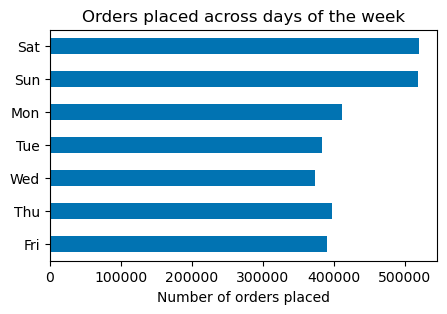

In [69]:
#plotting orders distribution per day of week

plt.figure(figsize=(5,3))
bar_dow = df_to_display.plot.barh(color = sns.color_palette("colorblind")[0], legend=None)
plt.xlabel('Number of orders placed')
plt.ylabel('')
plt.title('Orders placed across days of the week')

In [70]:
# extracting the data to be displayed

df_to_display = df_orders.groupby(['orders_day_of_week'])['ord_cost'].sum()

Text(0.5, 1.0, 'Revenue across days of the week')

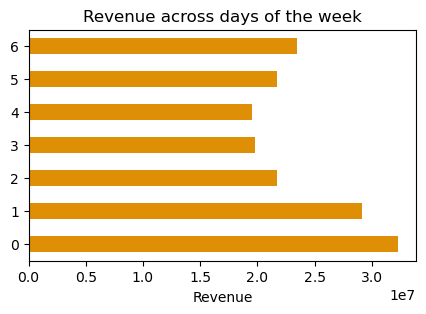

In [71]:
#plotting orders distribution per day of week

plt.figure(figsize=(5,3))
bar_total_per_day = df_to_display.plot.barh(color = sns.color_palette("colorblind")[1], legend=None)
plt.xlabel('Revenue')
plt.ylabel('')
plt.title('Revenue across days of the week')

In [72]:
# extracting the data to be displayed

df_to_display = df_orders['order_hour_of_day'].value_counts().rename_axis('hour_of_day').sort_index()

Text(0.5, 1.0, 'Distribution of orders placed across the hours of day')

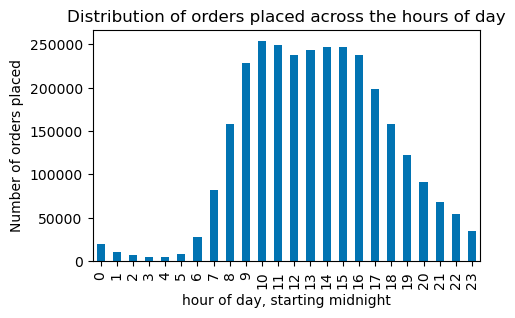

In [73]:
#plotting orders distribution per hour of day

plt.figure(figsize=(5,3))
bar_hod = df_to_display.plot.bar(color = sns.color_palette("colorblind")[0], legend=None)
plt.xlabel('hour of day, starting midnight')
plt.ylabel('Number of orders placed')
plt.title('Distribution of orders placed across the hours of day')

## Busiest times of the day

They also want to know whether there are particular times of the day when people spend the most money, as this might inform the type of products they advertise at these times.

In [74]:
df_to_display = df_orders.groupby(['order_hour_of_day'])['ord_cost'].sum()

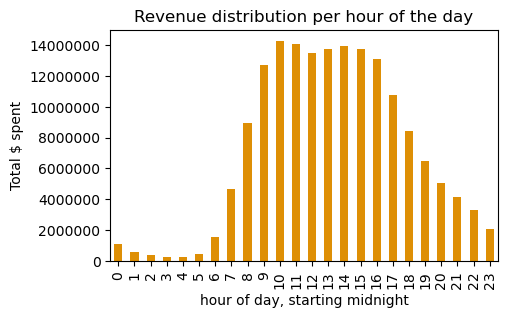

In [75]:
plt.figure(figsize=(5,3))
bar_total_per_hour = df_to_display.plot.bar(ylabel='Total $ spent', 
                                            xlabel='hour of day, starting midnight',
                                            color = sns.color_palette("colorblind")[1], 
                                            title='Revenue distribution per hour of the day')
plt.ticklabel_format(style='plain', axis='y')

**Comment**: Same shape as above, with number of orders

## Distribution of product prices

Instacart has a lot of products with different price tags. Marketing and sales want to use simpler price range groupings to help direct their efforts.

Text(0.5, 1.0, 'Histogram: Prices of products purchased')

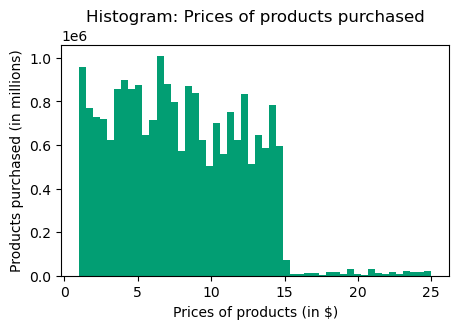

In [76]:
#plotting an histogram with the distribution of prices of products purchased, each bar is 0.5$ wide

plt.figure(figsize=(5,3))
hist_prices = df_ord_prod_cust['prices'].plot.hist(bins=50, color = sns.color_palette("colorblind")[2])
plt.xlabel('Prices of products (in $)')
plt.ylabel('Products purchased (in millions)')
plt.title('Histogram: Prices of products purchased')

In [77]:
# creating a dataframe with total of products (in catalog) within the price ranges previously defined

df_to_display = df_ord_prod_cust[['price_range_loc', 'product_id']].groupby(['price_range_loc']).nunique().sort_index()
df_to_display.rename_axis('price_range').rename(index={1:"Under $5",2:"Between \\$5 and $15",3:"Over $15"}, columns={'product_id':'number_of_products'})

,number_of_products
price_range,
Under $5,16216
Between \$5 and $15,32716
Over $15,545


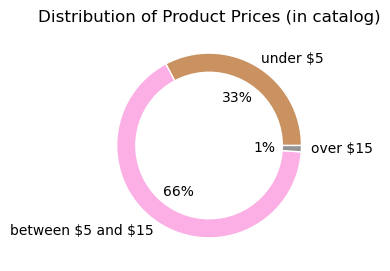

In [78]:
plt.figure(figsize=(3,3))
pie_price_dist_cat = df_to_display['product_id'].plot.pie(autopct=('%1.0f%%'), 
                                                              colors = sns.color_palette("colorblind")[5:8],
                                                              wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
                                                              legend=None, 
                                                              ylabel='', 
                                                              title='Distribution of Product Prices (in catalog)', 
                                                              labels=['under $5', 'between \\$5 and $15', 'over $15'])
center_circle = plt.Circle((0,0), 0.8, fc='white')
plt.gca().add_artist(center_circle)

In [79]:
# creating a dataframe with total of products (purchased by customers) within the price ranges previously defined

df_to_display = df_ord_prod_cust[['price_range_loc', 'product_id']].groupby(['price_range_loc']).count().sort_index()
df_to_display.rename_axis('price_range').rename(index={1:"Under $5",2:"Between \\$5 and $15",3:"Over $15"}, columns={'product_id':'total_products_purchased'})

,total_products_purchased
price_range,
Under $5,6774055
Between \$5 and $15,14625300
Over $15,275314


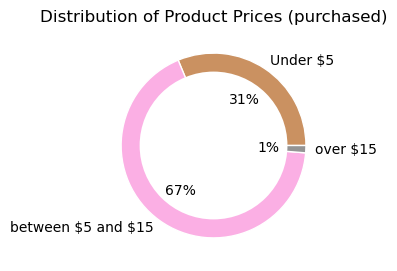

In [80]:
plt.figure(figsize=(3,3))
pie_price_dist_purch = df_to_display['product_id'].plot.pie(autopct=('%1.0f%%'), 
                                                            colors = sns.color_palette("colorblind")[5:8],
                                                            wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
                                                            legend=None, 
                                                            ylabel='', 
                                                            title='Distribution of Product Prices (purchased)', 
                                                            labels=['Under \\$5', 'between \\$5 and \\$15', 'over \\$15'])
center_circle = plt.Circle((0,0), 0.8, fc='white')
plt.gca().add_artist(center_circle)

## Departments popularity

Are there certain types of products that are more popular than others? The marketing and sales teams want to know which departments have the highest frequency of product orders.

In [81]:
# loading department dataframe

df_department = pd.read_csv(os.path.join(prep_data_path, 'departments_wrangled.csv'))
df_department.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  21 non-null     int64 
 1   department  21 non-null     object
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes


In [82]:
#renaming the field that contains the id's to merge ahead

df_department.rename(columns={'Unnamed: 0':'department_id'}, inplace=True)

In [83]:
# creating the dataframe with total of products purchased in each department, keeping only the top 10 to display

df_to_display = df_ord_prod_cust['department_id'].value_counts().sort_values().reset_index(name='products_sold').tail(10)

In [84]:
# merging dataframes, this way we have the dataframe names, and taking only the columns we want to show

df_to_display = df_to_display.merge(df_department, on='department_id')

In [85]:
# some cosmetics to make the dataframe with exactly 2 columns, department name as index and total products as column
# this makes the plot prettier, with bars correctly aligned

df_to_display.groupby(['department']).max('products_sold')
df_to_display.drop(columns='department_id',inplace=True)

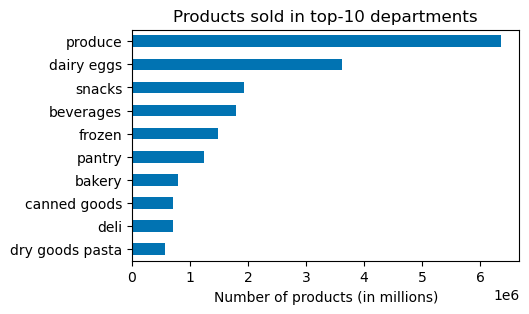

In [86]:
#plotting horizontal bar

bar_products_1 = df_to_display.plot.barh(x='department', color = sns.color_palette("colorblind")[0], legend=None)
plt.title('Products sold in top-10 departments')
plt.ylabel('')
plt.xlabel('Number of products (in millions)')
plt.gcf().set_size_inches(5,3)

In [87]:
# now let's find the top 10 departments, but for their total revenue

df_to_display = df_ord_prod_cust.groupby(['department_id'])['prices'].sum().sort_values().tail(10).to_frame()

In [88]:
# merging dataframes, this way we have the dataframe names, and taking only the columns we want to show

df_to_display = df_to_display.merge(df_department, on='department_id')

In [89]:
# some cosmetics to make the dataframe with exactly 2 columns, department name as index and total products as column
# this makes the plot prettier, with bars correctly aligned

df_to_display.groupby(['department']).max('prices')
df_to_display.drop(columns='department_id',inplace=True)

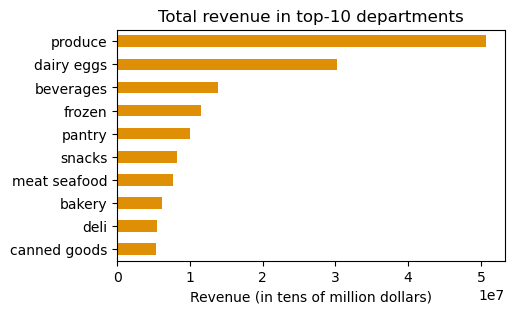

In [90]:
#plotting horizontal bar

bar_products_2 = df_to_display.plot.barh(x='department', color = sns.color_palette("colorblind")[1], legend=None)
plt.title('Total revenue in top-10 departments')
plt.ylabel('')
plt.xlabel('Revenue (in tens of million dollars)')
plt.gcf().set_size_inches(5,3)

## Ordering behaviours from customers

The marketing and sales teams are particularly interested in the different types of customers in their system and how their ordering behaviors differ.


*Ordering behaviours* can mean several different things. Some examples:

* most usual order day
* days in between orders
* average order cost
* total number of orders
* total spent

### Loyalty flag break down

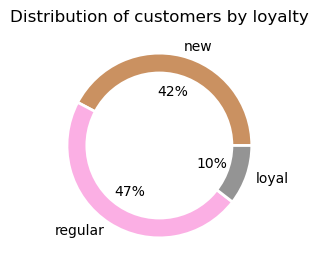

In [91]:
# distribution of customers by loyalty flag (loyalty flag was defined according to total of orders, in 3 layers)

plt.figure(figsize=(3,3))
df_to_display = df_customers['loyalty_flag'].value_counts().sort_index()
pie_loyalty_customers_1 = df_to_display.plot.pie(autopct=('%1.0f%%'), colors = sns.color_palette("colorblind")[5:8],
                                                 wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
                                                 legend=None, ylabel='', title='Distribution of customers by loyalty', 
                                                 labels =['new', 'regular', 'loyal'])
center_circle = plt.Circle((0,0), 0.8, fc='white')
plt.gca().add_artist(center_circle)

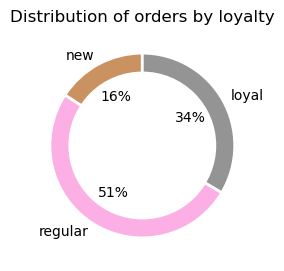

In [92]:
# distribution of the amount of orders placed by these 3 layers of loyalty customers

plt.figure(figsize=(3,3))
df_to_display = df_orders['loyalty_flag'].value_counts().sort_index()
pie_loyalty_customers_2 = df_to_display.plot.pie(autopct=('%1.0f%%'), colors = sns.color_palette("colorblind")[5:8],
                                               wedgeprops={'linewidth': 2, 'edgecolor': 'white'}, startangle = 90,
                                               legend=None, ylabel='', title='Distribution of orders by loyalty', 
                                               labels =['new', 'regular', 'loyal'])
center_circle = plt.Circle((0,0), 0.8, fc='white')
plt.gca().add_artist(center_circle)

### Loyalty_flag vs median_days_between_orders

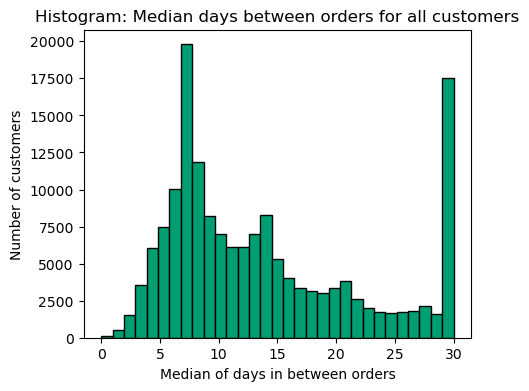

In [93]:
# plotting histogram with median_days_between_orders for all customers
# max of this variable is 30, the value here probably contains all record beyond this threshold (kind of artificial)

plt.figure(figsize=(5,4))
hist_median_days = df_customers['median_days_between_orders'].plot.hist(bins=31, 
                                                                        color=sns.color_palette("colorblind")[2],
                                                                        linewidth=1,
                                                                        edgecolor='black')
plt.xlabel('Median of days in between orders')
plt.ylabel('Number of customers')
plt.title('Histogram: Median days between orders for all customers')
plt.draw()

In [94]:
# creating a dictionaty for labeling

dict_loyalty = {1:'new',2:'regular',3:'loyal'}

In [95]:
# check how each loyalty group behaves in regards to this order frequency

df_grouped = df_ord_prod_cust.groupby(['loyalty_flag']).agg({'median_days_between_orders': ['min', 'max', 'mean']})
df_grouped.rename(index=dict_loyalty)

median_days_between_orders                 
                                    min   max       mean
loyalty_flag                                            
new                                 0.0  30.0  18.035789
regular                             0.0  30.0  10.612804
loyal                               0.0  14.0   5.170014

In [96]:
# crosstab median_days_between with loyalty flag, shown in percentages
# the reset index is needed so that 'median_days_between_orders' can be used later

df_crosstab = round(pd.crosstab(df_customers['median_days_between_orders'], df_customers['loyalty_flag'], normalize='columns')*100, 2).reset_index()
df_crosstab.rename(columns=dict_loyalty, inplace=True)
df_crosstab

loyalty_flag,median_days_between_orders,new,regular,loyal
0,0.0,0.10,0.02,0.11
1,0.5,0.01,0.00,0.00
2,1.0,0.28,0.14,1.07
3,1.5,0.01,0.00,0.02
4,2.0,0.50,0.51,4.51
...,...,...,...,...
56,28.0,2.38,0.56,0.00
57,28.5,0.12,0.03,0.00
58,29.0,1.71,0.37,0.00
59,29.5,0.11,0.02,0.00


In [97]:
#compute two dfs splitting the loyal customers in two groups, the ones with median less or equal than 7, or more than 7

df_loyal_less_eq_7 = df_crosstab.loc[df_crosstab['median_days_between_orders'] <= 7, 'loyal'].sum()
df_loyal_more_7    = df_crosstab.loc[df_crosstab['median_days_between_orders'] > 7, 'loyal'].sum()

Text(0.5, 1.0, 'Median days between orders for Loyal customers')

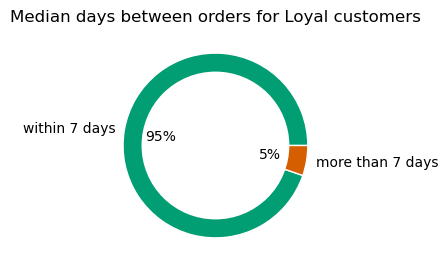

In [98]:
pie_days_loyal = plt.figure(figsize=(3,3))
plt.pie([df_loyal_less_eq_7,df_loyal_more_7],
        autopct=('%1.f%%'),
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        colors = sns.color_palette("colorblind")[2:4],
        labels=['within 7 days', 'more than 7 days'])
plt.ylabel('')
center_circle = plt.Circle((0,0), 0.8, fc='white')
plt.gca().add_artist(center_circle)
plt.title('Median days between orders for Loyal customers')

In [99]:
# exactly same analysis, but now for regular customers

df_regular_less_eq_7 = df_crosstab.loc[df_crosstab['median_days_between_orders'] <= 7, 'regular'].sum()
df_regular_more_7    = df_crosstab.loc[df_crosstab['median_days_between_orders'] > 7, 'regular'].sum()

Text(0.5, 1.0, 'Median days between orders for regular customers')

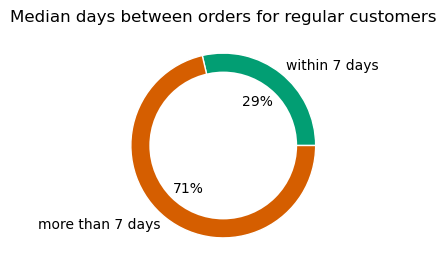

In [100]:
pie_days_regular = plt.figure(figsize=(3,3))
plt.pie([df_regular_less_eq_7,df_regular_more_7],
        autopct=('%1.f%%'),
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        colors = sns.color_palette("colorblind")[2:4],
        labels=['within 7 days', 'more than 7 days'])
plt.ylabel('')
center_circle = plt.Circle((0,0), 0.8, fc='white')
plt.gca().add_artist(center_circle)
plt.title('Median days between orders for regular customers')

In [101]:
# finally for new customers

df_new_less_eq_7 = df_crosstab.loc[df_crosstab['median_days_between_orders'] <= 7, 'new'].sum()
df_new_more_7    = df_crosstab.loc[df_crosstab['median_days_between_orders'] > 7, 'new'].sum()

Text(0.5, 1.0, 'Median days between orders for new customers')

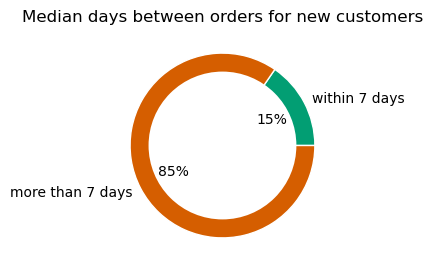

In [102]:
pie_days_new = plt.figure(figsize=(3,3))
plt.pie([df_new_less_eq_7,df_new_more_7],
        autopct=('%1.f%%'),
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        colors = sns.color_palette("colorblind")[2:4],
        labels=['within 7 days', 'more than 7 days'])
plt.ylabel('')
center_circle = plt.Circle((0,0), 0.8, fc='white')
plt.gca().add_artist(center_circle)
plt.title('Median days between orders for new customers')

In [103]:
category_names = ['within 7 days', 'more than 7 days']

In [104]:
lst_loyal_values = [df_loyal_less_eq_7, df_loyal_more_7]
lst_regular_values = [df_regular_less_eq_7, df_regular_more_7]
lst_new_values = [df_new_less_eq_7, df_new_more_7]

In [105]:
values_dict={'Loyal': [round(x,0) for x in lst_loyal_values],
             'Regular': [round(x,0) for x in lst_regular_values],
             'New': [round(x,0) for x in lst_new_values]}

In [106]:
# This function was inspired and adapted from the example in the url below
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html#sphx-glr-gallery-lines-bars-and-markers-horizontal-barchart-distribution-py

def stacked_barh_chart(values_dict, category_names):
    """
    Parameters
    ----------
    values_dict : dict
        A mapping with the values for each label we want.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(values_dict.keys())
    data = np.array(list(values_dict.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['Greens'](
        np.linspace(0.30, 0.60, data.shape[1]))

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.7,
                        label=colname, color=color)
        ax.bar_label(rects, label_type='center', color='black')
    ax.legend(ncols=len(category_names), loc='upper right', fontsize='small')

    return fig

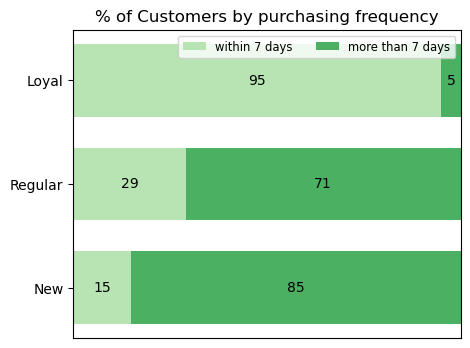

In [107]:
barh_median_by_loyalty = stacked_barh_chart(values_dict, category_names)
plt.title('% of Customers by purchasing frequency')
plt.show()

### Loyalty_flag vs region

In [108]:
#crosstab region with loyalty flag, shown in percentages

df_crosstab = round(pd.crosstab(df_customers['loyalty_flag'], df_customers['region'], normalize='columns')*100, 2)
df_crosstab.rename(index=dict_loyalty, inplace=True)
df_crosstab

region,MidWest,Northeast,South,West
loyalty_flag,,,,
new,42.19,42.20,42.34,42.31
regular,47.41,47.21,47.26,47.17
loyal,10.40,10.59,10.40,10.52


**Comment**: No region stands out, the national distribution is fairly equal among all regions.

### Loyalty_flag vs income bracket

In [109]:
# crosstab income range with loyalty flag, shown in percentages

df_crosstab = round(pd.crosstab(df_customers['loyalty_flag'], df_customers['income_range'], normalize='columns')*100, 2)
df_crosstab.rename(columns=dict_incomes, inplace=True)
df_crosstab.rename(index=dict_loyalty, inplace=True)
df_crosstab

income_range,low,mid low,mid high,high,top
loyalty_flag,,,,,
new,45.83,41.16,41.16,41.22,26.87
regular,45.03,47.76,48.02,48.06,56.78
loyal,9.13,11.07,10.82,10.72,16.35


**Comment**: There is a slight percentual shift in loyalty when income bracket increases, meaning that the bigger the income is, the bigger the chances are that a customer goes loyal.

### loyalty_flag vs frozen stuff

In [110]:
# the same crosstab technique as above, but with a slight difference on how to calculate percentage values

df_crosstab = round(pd.crosstab(df_customers['frozen_stuff'], df_customers['loyalty_flag'], normalize='columns')*100, 2)
df_crosstab.rename(columns=dict_loyalty, inplace=True)
df_crosstab

loyalty_flag,new,regular,loyal
frozen_stuff,,,
False,28.45,15.03,8.3
True,71.55,84.97,91.7


### loyalty_flag vs baby_stuff

In [111]:
# the same crosstab technique as above, but with a slight difference on how to calculate percentage values

df_crosstab = round(pd.crosstab(df_customers['baby_stuff'], df_customers['loyalty_flag'], normalize='columns')*100, 2)
df_crosstab.rename(columns=dict_loyalty, inplace=True)
df_crosstab

loyalty_flag,new,regular,loyal
baby_stuff,,,
False,89.54,81.2,65.53
True,10.46,18.8,34.47


**Comment**: In these two types of products (frozen stuff purchased frequently by all customers, baby stuff more seldomly purchased) one pattern stands out, and this is most likely characteristic in all departments:

The loyal group shows the biggest percentage of customers purchasing these products than any other group. This is way more evident in baby department. 

### most common order day vs loyalty flag

In [112]:
df_to_display = df_customers['common_order_day'].value_counts().sort_index(ascending=True).rename(index=dict_dow)

In [113]:
df_to_display

common_order_day
Sat    39760
Sun    32156
Mon    18693
Tue    16202
Wed    15154
Thu    18094
Fri    22572
Name: count, dtype: int64

Text(0.5, 1.0, 'Frequency of most common order days')

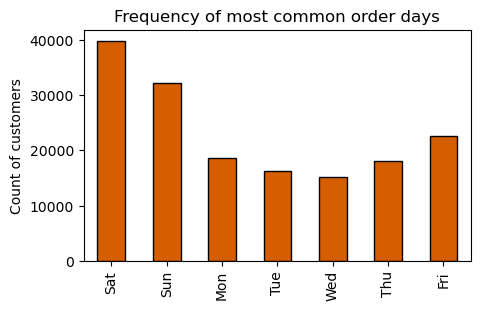

In [114]:
plt.figure(figsize=(5,3))
bar_common_day = df_to_display.plot.bar(color = sns.color_palette("colorblind")[3],
                                        linewidth=1,
                                        edgecolor='black')
plt.xlabel('')
plt.ylabel('Count of customers')
plt.title('Frequency of most common order days')

**Comment**: This result is completely in line with the overall busiest days of the week

In [115]:
# crosstab between common order day and loyalty flag

df_crosstab = round(pd.crosstab(df_customers['common_order_day'], df_customers['loyalty_flag'], normalize='columns')*100, 2)
df_crosstab.sort_index(ascending=False, inplace=True)
df_crosstab.rename(index=dict_dow, columns=dict_loyalty, inplace=True)
df_crosstab

loyalty_flag,new,regular,loyal
common_order_day,,,
Fri,13.60,14.41,12.63
Thu,11.11,10.85,12.41
Wed,9.95,8.93,8.52
Tue,10.82,9.53,8.44
Mon,12.39,11.11,9.61
Sun,18.41,19.93,24.56
Sat,23.72,25.24,23.83


Text(0, 0.5, '')

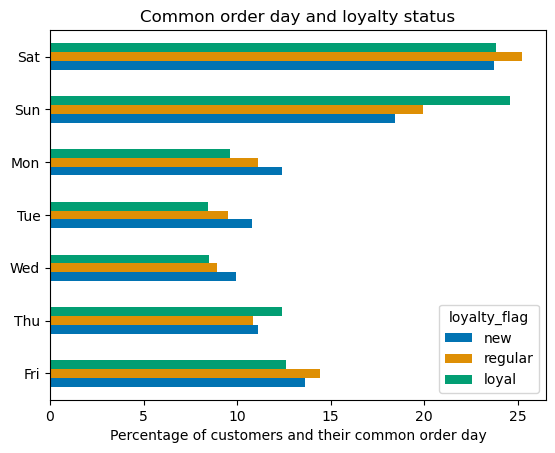

In [116]:
#plotting the result of the table above

bar_common_day_loyalty = df_crosstab.plot.barh(color = sns.color_palette("colorblind")[0:3])
plt.title('Common order day and loyalty status')
plt.xlabel('Percentage of customers and their common order day')
plt.ylabel('')

**Comment**: We can spot a slight difference in loyal customers, where there is a shift in the preferred day to Sunday, compared with the other two groups, and the overall scenario. Another observations is that new customers are the ones that spread more their preferred day to place orders

### most common order day vs income bracket

In [117]:
# crosstab between common order day and income range

df_crosstab = round(pd.crosstab(df_customers['common_order_day'], df_customers['income_range'], normalize='columns')*100, 2)
df_crosstab.sort_index(ascending=False, inplace=True)
df_crosstab.rename(index=dict_dow,columns=dict_incomes, inplace=True)
df_crosstab

income_range,low,mid low,mid high,high,top
common_order_day,,,,,
Fri,12.50,14.07,14.45,14.54,12.42
Thu,11.69,10.91,10.85,11.03,12.80
Wed,10.18,9.05,9.02,9.04,8.24
Tue,11.04,9.61,9.69,9.54,8.24
Mon,12.56,11.19,11.16,11.02,13.05
Sun,21.30,19.32,19.37,19.06,21.04
Sat,20.75,25.85,25.46,25.77,24.21


Text(0, 0.5, '')

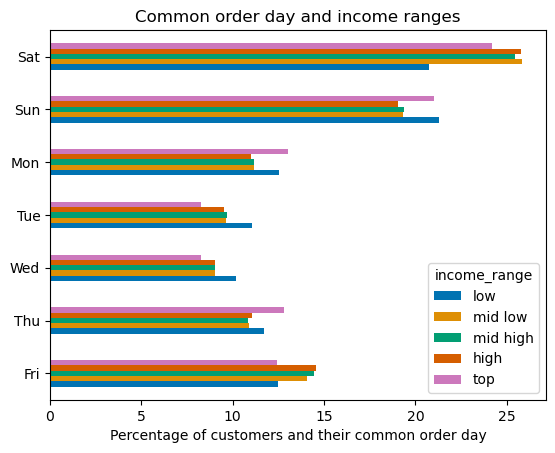

In [118]:
#plotting the result of the table above

bar_common_day_income = df_crosstab.plot.barh(color = sns.color_palette("colorblind")[0:5])
plt.title('Common order day and income ranges')
plt.xlabel('Percentage of customers and their common order day')
plt.ylabel('')

pet stuff and baby stuff

In [119]:
df_crosstab = round(pd.crosstab(df_customers['baby_stuff'], df_customers['pet_stuff'], normalize=True)*100,2)
df_crosstab

pet_stuff,False,True
baby_stuff,,
False,77.33,5.76
True,15.48,1.43


### hours vs snacks/frozen stuff

In [120]:
# distribution of orders including snacks and periods of day

df_crosstab = round(pd.crosstab(df_orders['busiest_period_of_day'], df_orders['snacks_stuff'], normalize='index')*100, 2)
df_crosstab.rename(index=dict_busy_pod)

snacks_stuff,False,True
busiest_period_of_day,,
less busy,9.50,90.50
average,8.13,91.87
peak,7.94,92.06


In [121]:
# distribution of orders including frozen stuff and periods of day

df_crosstab = round(pd.crosstab(df_orders['busiest_period_of_day'], df_orders['frozen_stuff'], normalize='index')*100, 2)
df_crosstab.rename(index=dict_busy_pod)

frozen_stuff,False,True
busiest_period_of_day,,
less busy,12.33,87.67
average,11.81,88.19
peak,14.40,85.60


### total spend and state average order cost

In [122]:
# creating a dataframe for states with the global values purchased and global numbers of orders

df_state = df_customers.groupby(['state']).agg({'total_purch_per_user': 'sum', 'max_order': 'sum'}).sort_values(by='max_order', ascending=False)
df_state.rename(columns={'total_purch_per_user':'state_lifetime_total','max_order':'state_total_orders'},inplace=True)
df_state.head()

,state_lifetime_total,state_total_orders
state,,
Pennsylvania,3482579.25,62357
New Mexico,3419442.50,62082
Alabama,3320540.25,61816
Georgia,3419755.25,61573
California,3431514.00,61537


In [123]:
#deriving average value per order in state level

df_state['state_order_avg'] = df_state['state_lifetime_total'] / df_state['state_total_orders']

In [124]:
# checking which states are on top of average per order

df_state.sort_values(by='state_order_avg', ascending=False).head()

,state_lifetime_total,state_total_orders,state_order_avg
state,,,
Rhode Island,3421454.00,60008,57.016631
Arizona,3409585.75,60672,56.197023
Louisiana,3317758.00,59231,56.013878
Mississippi,3297731.25,58905,55.983894
Arkansas,3329797.25,59512,55.951695


In [125]:
# checking which states are on bottom of average per order

df_state.sort_values(by='state_order_avg', ascending=False).tail()

,state_lifetime_total,state_total_orders,state_order_avg
state,,,
Washington,3291068.25,60855,54.080491
Florida,3283236.75,60711,54.079767
Alabama,3320540.25,61816,53.716518
Vermont,3173953.50,59340,53.487588
District of Columbia,3193701.50,59711,53.485982


Here I will be calculating the dispersion coefficients for the 3 metrics above, using the formula:

$$(Max Value - Min Value) / (Max Value + Min Value)$$

The advantages I see this coefficient instead of others are:
* simple to use and calculate
* provides a value from 0 to 1, unit-free, which is great to compare variables in total different scales and/or units
* it's sensitive to outliers, which in this case is a good thing, because I want to show all values are super concentrated

In [126]:
# dispersion coefficients calculation

disp_coef_lifetime = (df_state['state_lifetime_total'].max() - df_state['state_lifetime_total'].min())/(df_state['state_lifetime_total'].max() + df_state['state_lifetime_total'].min())
disp_coef_total_ord = (df_state['state_total_orders'].max() - df_state['state_total_orders'].min())/(df_state['state_total_orders'].max() + df_state['state_total_orders'].min())
disp_coef_order_avg = (df_state['state_order_avg'].max() - df_state['state_order_avg'].min())/(df_state['state_order_avg'].max() + df_state['state_order_avg'].min())

In [127]:
# showing results

print("Dispersion coefficients:\n\nState Lifetime total: {0:2.2%}\nState total orders: {1:2.2%}\nState order average: {2:2.2%}"
    .format(disp_coef_lifetime, disp_coef_total_ord, disp_coef_order_avg))

Dispersion coefficients:

State Lifetime total: 4.97%
State total orders: 4.28%
State order average: 3.20%


### age range vs income

In [128]:
# checking relationship between age and incomes

df_crosstab = round(pd.crosstab(df_customers['income_range'], df_customers['age_flag'], normalize='columns')*100, 2)
df_crosstab.rename(index=dict_incomes, columns=dict_ages, inplace=True)
df_crosstab

age_flag,young adults,early middle age,late middle age,senior
income_range,,,,
low,39.75,25.89,16.92,16.61
mid low,49.70,26.28,11.27,11.28
mid high,9.75,24.06,33.45,33.62
high,0.55,23.27,37.76,37.89
top,0.25,0.50,0.60,0.60


**Comment**: It can be some kind of correlation between both variables, an advance in age corresponds to a shift in the number of customers with better incomes.

In [129]:
#creating a list to apply in the plot below, using the percentiles used for the split in incomes

low_limit = round(srs_cust_income.quantile(.25)/1000)
midlow_limit = round(srs_cust_income.quantile(.5)/1000)
midhigh_limit = round(srs_cust_income.quantile(.75)/1000)
high_limit = round(outlier_upper_limit/1000)

lst_incomes = [f"Under {low_limit}k",
               f"Between {low_limit} and {midlow_limit}k",
               f"Between {midlow_limit} and {midhigh_limit}k",
               f"Between {midhigh_limit} and {high_limit}k",
               f"Above {high_limit}k"]

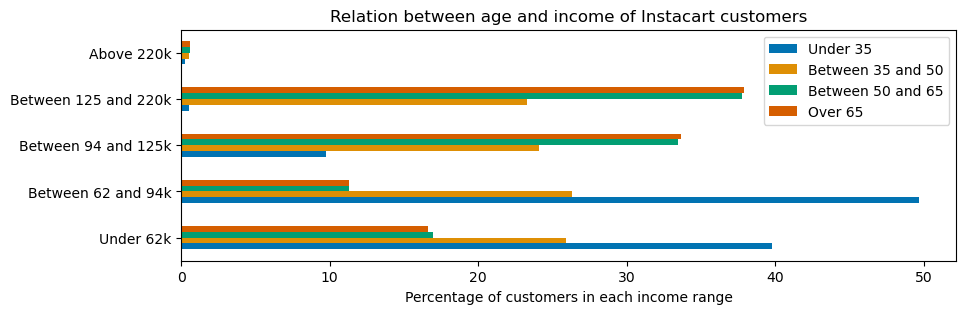

In [130]:
# plotting the result above

bar_age_income = df_crosstab.plot.barh(color = sns.color_palette("colorblind"),
                                       figsize=(10,3),
                                       title='Relation between age and income of Instacart customers')
plt.yticks([0,1,2,3,4], labels=lst_incomes)
plt.ylabel('')
plt.xlabel('Percentage of customers in each income range')
plt.legend(['Under 35','Between 35 and 50','Between 50 and 65','Over 65'])

In [131]:
# repeating the above, but now between age and loyalty status

df_crosstab = round(pd.crosstab(df_customers['loyalty_flag'], df_customers['age_flag'], normalize='columns')*100, 2)
df_crosstab.rename(index=dict_loyalty, columns=dict_ages, inplace=True)
df_crosstab

age_flag,young adults,early middle age,late middle age,senior
loyalty_flag,,,,
new,42.46,42.07,42.50,42.06
regular,47.22,47.43,46.98,47.42
loyal,10.32,10.50,10.52,10.52


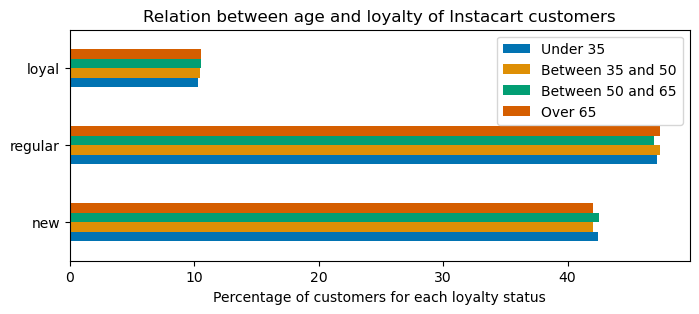

In [132]:
bar_age_loyalty = df_crosstab.plot.barh(color = sns.color_palette("colorblind"),
                                        figsize=(8,3),
                                        title='Relation between age and loyalty of Instacart customers')
plt.yticks([0,1,2], labels=list(dict_loyalty.values()))
plt.ylabel('')
plt.xlabel('Percentage of customers for each loyalty status')
plt.legend(['Under 35','Between 35 and 50','Between 50 and 65','Over 65'])

# Exporting Plots

In [133]:
# exporting all figures
# bbox_inches setup as 'tight' is to ensure that whatever figsize was selected, the exports are not cropped

bar_dow.figure.savefig(os.path.join(vis_path, 'bar_dow.png'), bbox_inches='tight')

In [134]:
bar_hod.figure.savefig(os.path.join(vis_path, 'bar_hod.png'), bbox_inches='tight')

In [135]:
bar_total_per_hour.figure.savefig(os.path.join(vis_path, 'bar_total_per_hour.png'), bbox_inches='tight')

In [136]:
bar_total_per_day.figure.savefig(os.path.join(vis_path, 'bar_total_per_day.png'), bbox_inches='tight')

In [137]:
hist_prices.figure.savefig(os.path.join(vis_path, 'hist_prices.png'), bbox_inches='tight')

In [138]:
pie_price_dist_cat.figure.savefig(os.path.join(vis_path, 'pie_price_dist_cat.png'), bbox_inches='tight')

In [139]:
pie_price_dist_purch.figure.savefig(os.path.join(vis_path, 'pie_price_dist_purch.png'), bbox_inches='tight')

In [140]:
bar_products_1.figure.savefig(os.path.join(vis_path, 'bar_products_1.png'), bbox_inches='tight')

In [141]:
bar_products_2.figure.savefig(os.path.join(vis_path, 'bar_products_2.png'), bbox_inches='tight')

In [142]:
pie_loyalty_customers_1.figure.savefig(os.path.join(vis_path, 'pie_loyalty_customers_1.png'), bbox_inches='tight')

In [143]:
pie_loyalty_customers_2.figure.savefig(os.path.join(vis_path, 'pie_loyalty_customers_2.png'), bbox_inches='tight')

In [144]:
hist_median_days.figure.savefig(os.path.join(vis_path, 'hist_median_days.png'), bbox_inches='tight')

In [145]:
pie_days_loyal.figure.savefig(os.path.join(vis_path, 'pie_days_loyal.png'), bbox_inches='tight')

In [146]:
pie_days_regular.figure.savefig(os.path.join(vis_path, 'pie_days_regular.png'), bbox_inches='tight')

In [147]:
pie_days_new.figure.savefig(os.path.join(vis_path, 'pie_days_new.png'), bbox_inches='tight')

In [148]:
bar_common_day.figure.savefig(os.path.join(vis_path, 'bar_common_day.png'), bbox_inches='tight')

In [149]:
bar_common_day_loyalty.figure.savefig(os.path.join(vis_path, 'bar_common_day_loyalty.png'), bbox_inches='tight')

In [150]:
bar_common_day_income.figure.savefig(os.path.join(vis_path, 'bar_common_day_income.png'), bbox_inches='tight')

In [151]:
bar_age_income.figure.savefig(os.path.join(vis_path, 'bar_age_income.png'), bbox_inches='tight')

In [152]:
bar_age_loyalty.figure.savefig(os.path.join(vis_path, 'bar_age_loyalty.png'), bbox_inches='tight')

In [153]:
barh_median_by_loyalty.figure.savefig(os.path.join(vis_path, 'barh_median_by_loyalty.png'), bbox_inches='tight')